In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as of
import plotly.graph_objs as go
from show_img import show_img
from model import my_model
from plot_conf import plot_conf
of.offline.init_notebook_mode(connected=True)
import h5py

## Show 3D image 

In [2]:
show_img()

## Image processing

In [3]:
for dirname,_, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

with h5py.File('archive/full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)
print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array

for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])


xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

print(xtrain.shape)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)
(10000, 16, 16, 16, 3)


## Initial Model and setting hyperparameter

## Training and save model

In [4]:
checkpoint_path = "training/cp-1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
    verbose=1, save_weights_only=True)

model = my_model()
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.build(input_shape=(None, 16,16,16,3))
model.summary()

model.save_weights(checkpoint_path.format(epoch=0))
model.fit(x=xtrain, y=y_train, batch_size=128, epochs=1, validation_split=0.2)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 16, 3)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 16, 16, 16, 8)     656       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16, 8)     32        
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 16, 16, 8)     1736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16, 8)     32        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 8, 8, 8)        0     

## Test

In [11]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
model = my_model()
model.evaluate(x=xtest,y=y_test)
predictions = model.predict(xtest)
pred_class = tf.math.argmax(predictions,1)

63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00


## Plot confusion matrix 

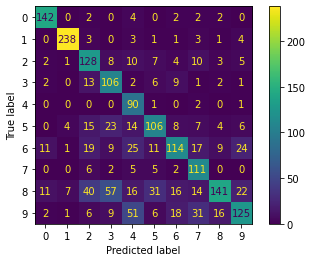

In [ ]:
plot_conf(pred_class, y_test)